# Amazon Nova Image Grounding notebook

Amazon Nova have a strong ability for image grounding task, include open world and screenshots.

The output bounding box in in scale [0, 1000), that you need to rescale the model output coordinates to the original image size.



In [ ]:
%pip install boto3 Pillow

In [2]:
import base64
import boto3
import io
import json
import re

from PIL import Image, ImageDraw, ImageFont


modelId = "us.amazon.nova-lite-v1:0"
accept = "application/json"
contentType = "application/json"
bedrock_rt = boto3.client("bedrock-runtime", region_name="us-east-1") 

Define a helper function for better loading model output as json.

In [3]:

def safe_json_load(json_string):
    try:
        json_string = re.sub(r"\s", "", json_string)
        json_string = re.sub(r"\(", "[", json_string)
        json_string = re.sub(r"\)", "]", json_string)
        bbox_set = {}
        for b in re.finditer(r"\[\d+,\d+,\d+,\d+\]", json_string):
            if b.group(0) in bbox_set:
                json_string = json_string[:bbox_set[b.group(0)][1]] + "}]"
                break
            bbox_set[b.group(0)] = (b.start(), b.end())
        else:
            json_string = json_string[:bbox_set[b.group(0)][1]] + "}]"
        json_string = re.sub(r"\]\},\]$", "]}]", json_string)
        json_string = re.sub(r"\]\],\[\"", "]},{\"", json_string)
        json_string = re.sub(r"\]\],\[\{\"", "]},{\"", json_string)
        return json.loads(json_string)
    except Exception as e:
        print(e)
        return []

Invoke Amazon Nova for image detection, you need to define the detection task by prompt. Here is the prompt for specific object detection, and you can define you own prompt based on your needs.

In [4]:
def detection(image_path, category_list, image_short_size=360):
    image_pil = Image.open(image_path)
    width, height = image_pil.size

    ratio = image_short_size/ min(width, height)
    width = round(ratio * width)
    height = round(ratio * height)

    image_pil = image_pil.resize((width, height), resample=Image.Resampling.LANCZOS)
    buffer = io.BytesIO()
    image_pil.save(buffer, format="webp", quality=90)
    image_data = buffer.getvalue()


    category_str = ",".join([f'"{category}"' for category in category_list])
    
    prompts = """
Detect bounding box of objects in the image, only detect %s category objects with high confidence, output in a list of bounding box format.
Output example:
[
    {"%s": [x1, y1, x2, y2]},
    ...
]
""" % (category_str, category_list[0])
    prefill="""[
    {"
"""

    print("Input Prompt:\n", prompts)

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "image": {
                        "format": 'webp',
                        "source": {
                            "bytes": image_data,
                        }
                    }
                },
                {
                    "text": prompts
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "text": prefill
                },
            ],
        }
    ]

    response = bedrock_rt.converse(
        modelId=modelId, messages=messages,
        inferenceConfig={
            "temperature": 0.0,
            "maxTokens": 1024,
        },
    )
    output = prefill + response.get('output')["message"]["content"][0]["text"]

    result = safe_json_load(output)

    color_list = [
        'blue',
        'green',
        'yellow',
        'red',
        'orange',
        'pink',
        'purple',
    ]
    font = ImageFont.truetype("Arial", size=height // 20)

    print("Result:\n")
    for idx, item in enumerate(result):
        label = next(iter(item))
        bbox = item[label]
        x1, y1, x2, y2 = bbox
        if x1 >= x2 or y1 >= y2:
            continue
        w, h = image_pil.size
        x1 = x1 / 1000 * w
        x2 = x2 / 1000 * w
        y1 = y1 / 1000 * h
        y2 = y2 / 1000 * h
        bbox = (x1, y1, x2, y2)
        bbox = list(map(round, bbox))
        print(f"Detect <{label}> in {bbox}")
        # draw bounding box
        draw = ImageDraw.Draw(image_pil)
        color = color_list[idx % len(color_list)]
        draw.rectangle(bbox, outline=color, width=2)
        draw.text((x1 + 4, y1 + 2), label, fill=color, font=font)
    return image_pil


Here are some examples:

Input Prompt:
 
Detect bounding box of objects in the image, only detect "bottle" category objects with high confidence, output in a list of bounding box format.
Output example:
[
    {"bottle": [x1, y1, x2, y2]},
    ...
]

Result:

Detect <bottle> in [140, 65, 233, 292]


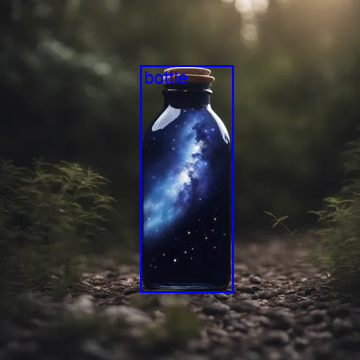

In [5]:
detection(
    "./media/bottle.webp", 
    category_list=["bottle"], 
)

Input Prompt:
 
Detect bounding box of objects in the image, only detect "car","dog","cat" category objects with high confidence, output in a list of bounding box format.
Output example:
[
    {"car": [x1, y1, x2, y2]},
    ...
]

Result:

Detect <car> in [216, 75, 327, 174]
Detect <car> in [59, 103, 177, 181]
Detect <dog> in [51, 144, 362, 290]
Detect <cat> in [396, 142, 492, 306]


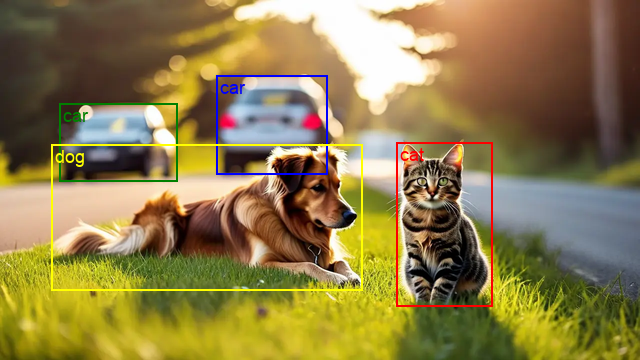

In [6]:
detection(
    "./media/cat_dog_car.webp", 
    category_list=["car", "dog", "cat"], 
)

Input Prompt:
 
Detect bounding box of objects in the image, only detect "cake" category objects with high confidence, output in a list of bounding box format.
Output example:
[
    {"cake": [x1, y1, x2, y2]},
    ...
]

Result:

Detect <cake> in [82, 322, 234, 479]
Detect <cake> in [169, 230, 329, 379]


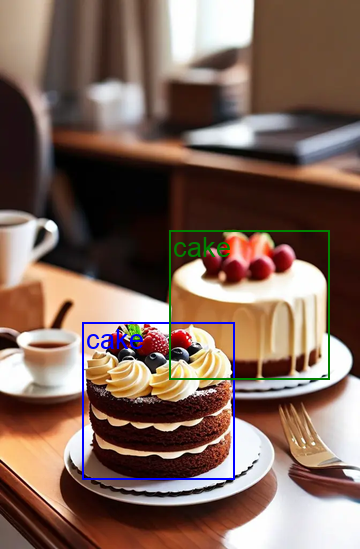

In [7]:
detection(
    "./media/cakes.webp", 
    category_list=["cake"], 
)

Input Prompt:
 
Detect bounding box of objects in the image, only detect "unripe_strawberry" category objects with high confidence, output in a list of bounding box format.
Output example:
[
    {"unripe_strawberry": [x1, y1, x2, y2]},
    ...
]

Result:

Detect <unripe_strawberry> in [145, 170, 253, 312]
Detect <unripe_strawberry> in [204, 108, 271, 194]
Detect <unripe_strawberry> in [394, 122, 476, 240]


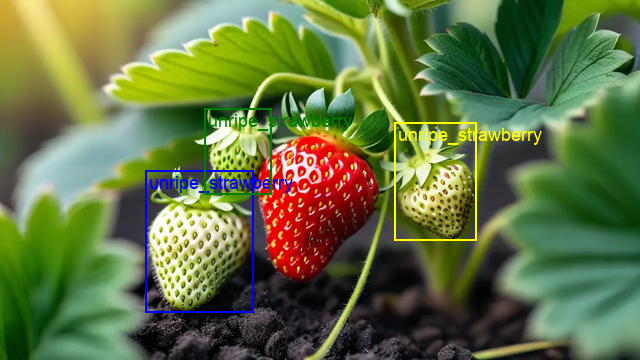

In [8]:
detection(
    "./media/unripe_strawberry.webp", 
    category_list=["unripe_strawberry"], 
)